In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rxa
import matplotlib.pyplot as plt

# get uavsar VV coherence, int, unw, inc, dem

In [2]:
data_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar')
ncs_dir = data_dir.joinpath('ncs')
tif_dir = data_dir.joinpath('tifs', 'Lowman, CO')

In [5]:
ints = [None] * len(list(tif_dir.glob('lowman_232*_grd')))
cohs = [None] * len(list(tif_dir.glob('lowman_232*_grd')))
unws = [None] * len(list(tif_dir.glob('lowman_232*_grd')))
for i, pair_dir in enumerate(tif_dir.glob('lowman_232*_grd')):
    if i > 1:
        break
    print(pair_dir.stem)
    ann = pd.read_csv(next(pair_dir.glob('*.csv')), index_col=0)
    int = rxa.open_rasterio(next(pair_dir.glob('*VV_*int.grd.tiff'))).squeeze('band', drop = True)
    coh = rxa.open_rasterio(next(pair_dir.glob('*VV_*cor.grd.tiff'))).squeeze('band', drop = True)
    
    if i == 0:
        dem = rxa.open_rasterio(next(pair_dir.glob('*VV_*hgt.grd.tiff'))).squeeze('band', drop = True)
        dem.attrs['units'] = 'meters'
        dem.attrs['long_name'] = 'elevation'
        ref = dem
    
    int.attrs = ann.to_dict()
    int.attrs['units'] = 'radians'
    int.attrs['long_name'] = 'wrapped phase'
    int = int.expand_dims(time = [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 1'])])
    int = int.assign_coords(time2 = ('time', [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 2'])]))

    coh.attrs = ann.to_dict()
    coh.attrs['units'] = ''
    coh.attrs['long_name'] = 'coherence'
    coh = coh.expand_dims(time = [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 1'])])
    coh = coh.assign_coords(time2 = ('time', [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 2'])]))
    # dems.append(dem.interp_like(ref).expand_dims(time = [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 1'])]))

    ints[i] = int.interp_like(ref)
    cohs[i] = coh.interp_like(ref)

    if len(list(pair_dir.glob('*VV_*unw.grd.tiff'))) == 1:
        unw = rxa.open_rasterio(next(pair_dir.glob('*VV_*unw.grd.tiff'))).squeeze('band', drop = True)
        unw.attrs = ann.to_dict()
        unw.attrs['units'] = 'radians'
        unw.attrs['long_name'] = 'unwrapped phase'
        unw = unw.expand_dims(time = [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 1'])])
        unw = unw.assign_coords(time2 = ('time', [pd.to_datetime(ann.loc['value', 'start time of acquisition for pass 2'])]))
        unws[i] = unw.interp_like(ref)

lowman_23205_21009-004_21012-000_0007d_s01_L090_01_int_grd
lowman_23205_21015-008_21017-018_0007d_s01_L090_01_int_grd


In [7]:
ds = xr.Dataset()
ds['unw'] = xr.concat([i for i in unws if i is not None], dim = 'time', combine_attrs = 'drop_conflicts')
ds['int'] = xr.concat([i for i in ints if i is not None], dim = 'time', combine_attrs = 'drop_conflicts')
ds['cor'] = xr.concat([i for i in cohs if i is not None], dim = 'time', combine_attrs = 'drop_conflicts')

In [8]:
ds['dem'] = ref

In [9]:
ds['time'] = pd.to_datetime(ds['time'].data)

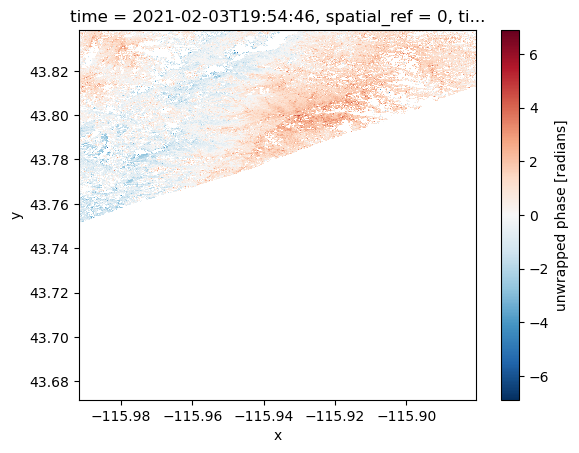

In [10]:
ds['unw'].isel(time = 0, x = slice(8000, 10000), y = slice(12000, 15000)).plot()

In [9]:
ds.to_netcdf(ncs_dir.joinpath('test.nc'))

MemoryError: 